# GCExplainer

In [1]:
import os,sys

parent = os.path.dirname(os.path.dirname(os.getcwd()))
if parent not in sys.path:
    sys.path.append(parent)

---

### Model & Data

In [2]:
# Data

from src.datasets.BACH import BACH
from torch_geometric.loader import DataLoader

src_folder  = "C:\\Users\\aless\\Documents\\data"
tid,vid = BACH.get_train_val_ids(src_folder)
train_set = BACH(src_folder,ids=tid,pre_encoded=True)
val_set = BACH(src_folder,ids=vid,pre_encoded=True)

train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=True)

print(len(train_loader))
print(len(val_loader))

308
76


In [43]:
# Model

from src.model.architectures.cancer_prediction.cancer_gnn import CancerGNN

model = CancerGNN.load_from_checkpoint(os.path.join(parent,"model", "GCNTopK_2.ckpt"),WIDTH=32)
model.eval()
model.requires_grad_(False)
print(model.gnn.predictor)

Sequential(
  (0): Dropout(p=0.8, inplace=False)
  (1): Linear(in_features=32, out_features=16, bias=True)
  (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.8, inplace=False)
  (5): Linear(in_features=16, out_features=4, bias=True)
)


---
## Dataset Metrics

In [44]:
import torch
def calculate_set_metric(loader,model,metric):
    tot = 0
    for batch in loader:
        ans = model(batch.x,batch.edge_index,batch.batch)
        tot += metric(ans,batch.y)
    return tot/len(loader)

def accuracy(ans,y):
    y_hat = ans.argmax(dim=1)
    return (y_hat == y).sum()

def cancer_accuracy(ans,y):
    y_hat = ans.argmax(dim=1)
    return (y_hat <=1) ==(y<=1 ).sum()
    
print("Training Loss",calculate_set_metric(train_loader,model,torch.nn.CrossEntropyLoss()))
print("Validation Loss",calculate_set_metric(val_loader,model,torch.nn.CrossEntropyLoss()))
print("Training Accuracy",calculate_set_metric(train_loader,model,accuracy))
print("Validation Accuracy",calculate_set_metric(val_loader,model,accuracy))
print("Training Cancer Accuracy",calculate_set_metric(train_loader,model,cancer_accuracy))
print("Validation Cancer Accuracy",calculate_set_metric(val_loader,model,cancer_accuracy))


Training Loss tensor(0.4821)
Validation Loss tensor(0.6527)
Training Accuracy tensor(0.8669)
Validation Accuracy tensor(0.7632)
Training Cancer Accuracy tensor([0.9416])
Validation Cancer Accuracy tensor([0.8553])


---

### Get Raw Activations

In [45]:

# Attach the hook

batch = next(iter(train_loader))
raw_activations = torch.zeros(0,32)

def append_raw_activations(self, input, output):
    global raw_activations
    raw_activations = torch.cat((raw_activations,output[0]),dim=0)



model.gnn.pool[-1].register_forward_hook(append_raw_activations)



In [46]:
# Acquire the activations
raw_activations = torch.zeros(0,32)

for batch in train_loader:
    model(batch.x,batch.edge_index,batch.batch)
    
#for batch in val_loader:
#    model(batch.x,batch.edge_index,batch.batch)

In [47]:
print(raw_activations.shape)

torch.Size([70323, 32])


---
# K Means

In [180]:

from scipy.cluster.vq import kmeans,whiten
import numpy as np
k = 10

tsne_size = 5000


obs = raw_activations.detach().numpy()
obs_white = whiten(obs)
means,_ = kmeans(obs_white,k_or_guess=k)

obs = obs[np.random.choice(np.arange(len(obs)),size=tsne_size,replace=False)]
obs_white = whiten(obs)


In [181]:
def nearest_mean(x,means):

    delta = (means - x)**2
    dists = delta.sum(axis=1)
    return dists.argmin()

def cluster(obs,means,k):
    clusters = [[] for i in range(k)]
    for i,x in enumerate(obs):
        clusters[nearest_mean(x,means)].append(i)
    return clusters
clusters = cluster(obs,means,k)

In [182]:
print(list(map(len,clusters)))

[256, 479, 519, 200, 510, 1255, 285, 785, 327, 384]


---
# Vizualize Explanations

In [183]:

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA



t =TSNE(n_components=2,learning_rate ='auto',init="pca",verbose=2,perplexity = 100,n_iter=1000).fit_transform(obs)
#reducer = PCA(n_components=2).fit(obs)
#reducer = KernelPCA(n_components=2,kernel="rbf",degree=2).fit(smaller_obs)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.565s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.415986
[t-SNE] Computed conditional probabilities in 0.313s


d:\Documents\git\XAI-Cancer-Diagnosis\XAI-Cancer-Diagnosis\venv\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 57.7103729, gradient norm = 0.0135004 (50 iterations in 1.043s)
[t-SNE] Iteration 100: error = 60.1777382, gradient norm = 0.0082272 (50 iterations in 1.088s)
[t-SNE] Iteration 150: error = 62.1874886, gradient norm = 0.0082361 (50 iterations in 1.062s)
[t-SNE] Iteration 200: error = 64.3556824, gradient norm = 0.0008644 (50 iterations in 1.024s)
[t-SNE] Iteration 250: error = 64.5791473, gradient norm = 0.0000886 (50 iterations in 0.982s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.579147
[t-SNE] Iteration 300: error = 1.3298819, gradient norm = 0.0014083 (50 iterations in 0.982s)
[t-SNE] Iteration 350: error = 1.0297500, gradient norm = 0.0005311 (50 iterations in 1.036s)
[t-SNE] Iteration 400: error = 0.9253798, gradient norm = 0.0002903 (50 iterations in 0.961s)
[t-SNE] Iteration 450: error = 0.8768941, gradient norm = 0.0001759 (50 iterations in 0.968s)
[t-SNE] Iteration 500: error = 0.8502001, gradient norm = 0.0001204 (50 

In [141]:

import matplotlib.pyplot as plt
from matplotlib import cm

def plot_clusters(cluster_ids,values):
    colours = cm.rainbow(np.linspace(0,1,len(cluster_ids)))
    for i,clust_ids in enumerate(cluster_ids):
        v = values[clust_ids]
        x,y = v[:,0],v[:,1]
        plt.scatter(x,y,color=colours[i])


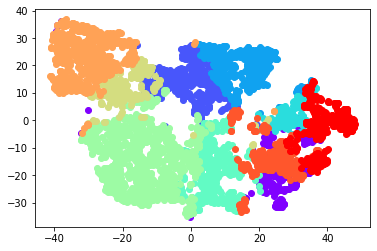

In [184]:
plot_clusters(clusters,t)
plt.show()

---
# Concept Completeness

In [57]:
# Activation Graph to Concept Graph


# Attach the hook

activation_graphs = []

def save_activation_graph(self, input, output):
    global activation_graphs
    activation_graphs.append(output)



model.gnn.pool[-1].register_forward_hook(save_activation_graph)



In [185]:
from torch.nn.functional import one_hot

def activation_to_concept(activation):
    return one_hot(torch.as_tensor(nearest_mean(activation,means)),len(means))

def activation_to_concept_graph(activation_graph):
    output = torch.zeros(0,k)
    for i in range(len(activation_graph[0])):
        concept = activation_to_concept(activation_graph[0][i].numpy()).unsqueeze(0)
        output = torch.cat([output,concept],dim=0)
    return output


def predict_concept_graph(graph):
    global activation_graphs
    activation_graphs = []
    model(graph.x,graph.edge_index,graph.batch)
    ag = activation_graphs[0]
    return activation_to_concept_graph(ag)



In [186]:
def concept_vs_cancer(loader): return [(predict_concept_graph(batch).mean(dim=0),batch.y) for batch in loader]

In [187]:
x_train = list(map(lambda x:list(map(lambda y:y.item(),x[0])),concept_vs_cancer(train_loader)))
y_train = list(map(lambda x:x[1].item(),concept_vs_cancer(train_loader)))

x_val = list(map(lambda x:list(map(lambda y:y.item(),x[0])),concept_vs_cancer(val_loader)))
y_val = list(map(lambda x:x[1].item(),concept_vs_cancer(val_loader)))

---
### CBE

In [203]:
## Linear Model
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

l = RandomForestClassifier(n_estimators=10000,max_depth=1000,random_state=0).fit(x_train,y_train)

print((l.predict(x_train) == y_train).mean())
print((l.predict(x_val) == y_val).mean())



0.9545454545454546
0.3157894736842105


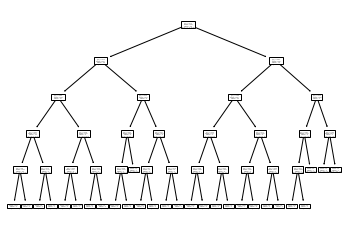

In [123]:
import sklearn.tree as tree

dectree = tree.DecisionTreeClassifier(max_depth=5,criterion="entropy").fit(x_train,y_train)
tree.plot_tree(dectree)
pass

In [124]:
(dectree.predict(x_train) == y_train).mean()

0.487012987012987

In [125]:
(dectree.predict(x_val) == y_val).mean()

0.19736842105263158